<center>
    <h1>Model evaluation and selection</h1>
    <br /><br />
    Gilles Louppe (<a href="https://twitter.com/glouppe">@glouppe</a>)
    <br /><br />
    New York University
</center>

In [1]:
# Global imports and settings

# Matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams["figure.max_open_warning"] = -1

# Print options
import numpy as np
np.set_printoptions(precision=3)

# Slideshow
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {'width': 1440, 'height': 768, 'scroll': True, 'theme': 'simple'})

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [2]:
%%javascript
Reveal.addEventListener("slidechanged", function(event){ window.location.hash = "header"; });

<IPython.core.display.Javascript object>

# Outline

* Model evaluation
* Model selection
* Selection and evaluation, _simultaneously_
* Bayesian optimization for model selection

# Model evaluation

## Evaluation

- Recall that we want to learn an estimator $f$ minimizing the generalization error $Err(f) = \mathbb{E}_{X,Y}[ L(Y, f(X)) ]$.

- Problem: Since $P_{X,Y}$ is unknown, the generalization error $Err(f)$ cannot be evaluated.

- Solution: Use a proxy to approximate $Err(f)$.

## Training error

In [3]:
# Generate data
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=20, random_state=123)
labels = ["b", "r"]
y = np.take(labels, (y < 10))

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X, y)
print("Training error =", zero_one_loss(y, clf.predict(X)))

Training error = 0.0


## Test error

Issue: the training error is a __biased__ estimate of the generalization error.

Solution: Divide ${\cal L}$ into two disjoint parts called training and test sets (usually using 70% for training and 30% for test).
- Use the training set for fitting the model;
- Use the test set for evaluation only, thereby yielding an better estimate of the generalization error.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
print("Training error =", zero_one_loss(y_train, clf.predict(X_train)))
print("Test error =", zero_one_loss(y_test, clf.predict(X_test)))

Training error = 0.104
Test error = 0.164


Summary: Beware of bias when you estimate model performance:
- Training score is often an optimistic estimate of the true performance;
- __The same data should not be used both for training and evaluation.__

## Cross-validation

Issue: 
- When ${\cal L}$ is small, training on 70% of the data may lead to a model that is significantly different from a model that would have been learned on the entire set ${\cal L}$ (high bias). 
- Yet, increasing the size of the training set (resp. decreasing the size of the test set), might lead to an inaccurate estimate of the generalization error (high variance). 

Solution: K-Fold cross-validation. 
- Split ${\cal L}$ into K small disjoint folds. 
- Train on K-1 folds, evaluate the test error one the held-out fold.
- Repeat for all combinations and average the K estimates of the generalization error.

<center><img src="img/cross-validation.png" /></center>

In [6]:
from sklearn.model_selection import KFold

scores = []

for train, test in KFold(n_splits=5, random_state=42).split(X):
    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]
    clf = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
    scores.append(zero_one_loss(y_test, clf.predict(X_test)))

print("CV error = %f +-%f" % (np.mean(scores), np.std(scores)))

CV error = 0.163000 +-0.010770


In [7]:
# Shortcut
from sklearn.model_selection import cross_val_score
scores = cross_val_score(KNeighborsClassifier(n_neighbors=5), X, y, 
                         cv=KFold(n_splits=5, random_state=42), 
                         scoring="accuracy")
print("CV error = %f +-%f" % (1. - np.mean(scores), np.std(scores)))

CV error = 0.163000 +-0.010770


How to chose K?
- With K=N, the cross-validation estimator is approximately unbiased for the true (expected) prediction error, but can have high variance because the N training sets are so similar to one another.
- On the other hand, when K is too small, cross-validation has lower variance but bias could be a problem, depending on how the learning method varies with the size of the training set. 
- Overall, 5 or 10-fold cross-validation are often recommended as a good compromise

<br />
<center><img src="img/cv-training-size.png" /></center>

## Wrap up example

In [8]:
# Generate a random classification problem
X = np.random.randn(500, 10000)     # 500 samples, 10000 features
y = np.random.randint(2, size=500)

# Select 10 most discriminative features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
tf = SelectKBest(f_regression, k=10).fit(X, y)
Xt = tf.transform(X)

In [9]:
# Train a classifier and evaluate its CV error
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
scores = cross_val_score(LogisticRegressionCV(), Xt, y, cv=5, scoring="accuracy")
print("CV error = %f +-%f" % (1. - np.mean(scores), np.std(scores)))

CV error = 0.298373 +-0.071012


<center>
Wait? We just built a classifier that is better than random, on random data!<br /><br />
<img src="img/meme.jpg" />
</center>

## Wrap up example: the right way

What have we done wrong?

<center>
*The same data should not be used both for training and evaluation.*
</center>

We used the full data to select the features we use for training the classifier. This selection is part of the algorithm and should be contained **inside** the cross-validation loop.

In [10]:
from sklearn.pipeline import make_pipeline
clf = make_pipeline(SelectKBest(f_regression, k=10), 
                    LogisticRegressionCV())
scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
print("CV error = %f +-%f" % (1. - np.mean(scores), np.std(scores)))

CV error = 0.458018 +-0.031997


## Metrics

### (Classification) Default score

Classifiers come built-in with the accuracy as default evaluation score.

Definition: The accuracy is the proportion of correct predictions. The closer to 1, the better.

In [11]:
# Generate data
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
X, y = make_blobs(n_samples=1000, centers=20, random_state=123)
labels = ["b", "r"]
y = np.take(labels, (y < 10))
X_train, X_test, y_train, y_test = train_test_split(X, y)
y_train = (y_train == "r")
y_test = (y_test == "r")

# Train
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train) 
print("Default score =", clf.score(X_test, y_test))  

Default score = 0.808


### (Classification)  Precision, recall and F-measure

$$Precision = \frac{TP}{TP + FP}$$
$$Recall = \frac{TP}{TP + FN}$$
$$F = \frac{2 * Precision * Recall}{Precision + Recall}$$

In [12]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
print("Precision =", precision_score(y_test, clf.predict(X_test)))
print("Recall =", recall_score(y_test, clf.predict(X_test)))
print("F =", fbeta_score(y_test, clf.predict(X_test), beta=1)) 

Precision = 0.774436090226
Recall = 0.851239669421
F = 0.811023622047


### (Classification)  ROC AUC

Definition: Area under the curve of the false positive rate (FPR) against the true positive rate (TPR) as the decision threshold of the classifier is varied.

ROC AUC = 0.905471202511


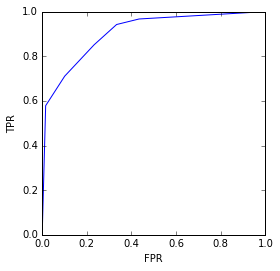

In [13]:
from sklearn.metrics import get_scorer
roc_auc_scorer = get_scorer("roc_auc")
print("ROC AUC =", roc_auc_scorer(clf, X_test, y_test))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

### (Classification) Confusion matrix

Definition: number of samples of class $i$ predicted as class $j$.

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, clf.predict(X_test))

array([[ 99,  30],
       [ 18, 103]])

### (Regression) Default score

Regressors come built-in with the R2 score as default evaluation score.

Definition: The R2 is the coefficient of determination. The closer to 1, the better. Note that the R2 score can be negative.

In [15]:
# Generate data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
X, y = make_regression(n_samples=1000, n_features=20)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Train
from sklearn.neighbors import KNeighborsRegressor
reg = KNeighborsRegressor(n_neighbors=5)
reg.fit(X_train, y_train) 
print("Default score =", reg.score(X_test, y_test))

Default score = 0.610913890431


### (Regression) Mean squared error


In [16]:
from sklearn.metrics import mean_squared_error
print("Mean squared error =", mean_squared_error(y_test, reg.predict(X_test)))

Mean squared error = 17673.2942084


### (Regression) Mean absolute error

In [17]:
from sklearn.metrics import mean_absolute_error
print("Mean absolute error =", mean_absolute_error(y_test, reg.predict(X_test)))

Mean absolute error = 108.377573272


# Model selection
 
- Finding good hyper-parameters is crucial to control under- and over-fitting, hence achieving better performance.
- The estimated generalization error can be used to select the best model.

## Under- and over-fitting

- Under-fitting: the model is too simple and does not capture the true relation between X and Y.
- Over-fitting: the model is too specific to the training set and does not generalize.

In [18]:
# Generate data
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=20, random_state=123)
labels = ["b", "r"]
y = np.take(labels, (y < 10))

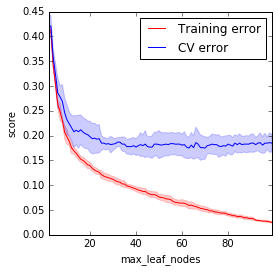

In [19]:
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeClassifier

# Evaluate parameter range in CV
param_range = range(2, 100)
param_name = "max_leaf_nodes"

train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(), X, y, 
    param_name=param_name, 
    param_range=param_range, cv=5, n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot parameter VS estimated error
plt.xlabel(param_name)
plt.ylabel("score")
plt.xlim(min(param_range), max(param_range))
plt.plot(param_range, 1. - train_scores_mean, color="red", label="Training error")
plt.fill_between(param_range, 
                 1. - train_scores_mean + train_scores_std,
                 1. - train_scores_mean - train_scores_std,
                 alpha=0.2, color="red")
plt.plot(param_range, 1. - test_scores_mean, color="blue", label="CV error")
plt.fill_between(param_range, 
                 1. - test_scores_mean + test_scores_std,
                 1. - test_scores_mean - test_scores_std, 
                 alpha=0.2, color="blue")
plt.legend(loc="best")

In [20]:
# Best trade-off
print("%s = %d, CV error = %f" % (param_name,
                                  param_range[np.argmax(test_scores_mean)],
                                   1. - np.max(test_scores_mean)))

max_leaf_nodes = 63, CV error = 0.175000


Question: Where is the model under-fitting and over-fitting?

Question: What does it mean if the training error is different from the test error?

## Hyper-parameter search

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

grid = GridSearchCV(KNeighborsClassifier(),
                    param_grid={"n_neighbors": list(range(1, 100))},
                    scoring="accuracy",
                    cv=5, n_jobs=-1)
grid.fit(X, y)  # Note that GridSearchCV is itself an estimator

print("Best score = %f, Best parameters = %s" % (1. - grid.best_score_, 
                                                 grid.best_params_))

Best score = 0.131000, Best parameters = {'n_neighbors': 34}


Question: Should you report the best score as an estimate of the generalization error of the model?

# Selection and evaluation, _simultaneously_

- `grid.best_score_` is not independent from the best model, since its construction was guided by the optimization of this quantity. 

- As a result, the optimized `grid.best_score_` estimate _may_ in fact be a biased, optimistic, estimate of the true performance of the model. 

- Solution: Use __nested__ cross-validation for correctly selecting the model __and__ correctly evaluating its performance. 

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

scores = cross_val_score(
            GridSearchCV(KNeighborsClassifier(),
                         param_grid={"n_neighbors": list(range(1, 100))},
                         scoring="accuracy",
                         cv=5, n_jobs=-1), 
            X, y, cv=5, scoring="accuracy")

# Unbiased estimate of the accuracy
print("%f +-%f" % (1. - np.mean(scores), np.std(scores)))

0.144000 +-0.023958


# Summary

- Model evaluation is the problem of quantifying the goodness of a model in expectation over the probability distribution of the data.
- Model selection is the problem of selecting the best model.
- Model evaluation and selection are often combined, but this should be done with care.

<center>
*The same data should not be used both for training and evaluation.*
</center>

In [ ]:
questions?